In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import streamlit as st
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

st.set_page_config(page_title="Fraud Detection AI", layout="wide") 
st.title("🧠 AI-Based Fraud Detection in Financial Transactions") 
st.markdown(""" This app uses AI models to detect fraudulent financial transactions, assigns risk scores, and provides an alert system with real-time visualization. """)
uploaded_file = st.file_uploader("Fraud Detection in Financial Transactions - DataSet.csv", type=["csv"])

# Load the dataset
df = pd.read_csv("Fraud Detection in Financial Transactions - DataSet.csv")

# Convert date columns to datetime
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])
df['PreviousTransactionDate'] = pd.to_datetime(df['PreviousTransactionDate'])

# Feature: Time since last transaction (in seconds)
df['TimeSinceLastTransaction'] = (
    df['TransactionDate'] - df['PreviousTransactionDate']
).dt.total_seconds()

2025-07-19 20:54:13.214 
  command:

    streamlit run C:\ProgramData\anaconda3\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]


In [8]:
# Drop unnecessary columns
df_model = df.drop(columns=[
    'TransactionID', 'AccountID', 'DeviceID', 'IP Address',
    'MerchantID', 'TransactionDate', 'PreviousTransactionDate'])

# Encode categorical features
label_encoders = {}
for col in df_model.select_dtypes(include='object'):
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col])
    label_encoders[col] = le

# Fill any missing values
df_model.fillna(0, inplace=True)

# Normalize select numeric columns for risk scoring
scaler = MinMaxScaler()
score_features = ['TransactionAmount', 'LoginAttempts', 'TransactionDuration', 'TimeSinceLastTransaction']
df_model[score_features] = scaler.fit_transform(df_model[score_features])

# Compute custom Risk Score (0 to 100)
df_model['RiskScore'] = (
    0.4 * df_model['TransactionAmount'] +
    0.2 * df_model['LoginAttempts'] +
    0.2 * df_model['TransactionDuration'] +
    0.2 * df_model['TimeSinceLastTransaction']) * 100

In [10]:
# Isolation Forest for anomaly detection
model = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
df_model['anomaly'] = model.fit_predict(df_model)
df_model['is_suspicious'] = df_model['anomaly'].apply(lambda x: 1 if x == -1 else 0)

# Add Alert Level based on Risk Score + anomaly
def generate_alert(row):
    if row['is_suspicious'] == 1 and row['RiskScore'] > 70:
        return "HIGH RISK"
    elif row['RiskScore'] > 50:
        return "REVIEW"
    else:
        return "SAFE"

df_model['AlertLevel'] = df_model.apply(generate_alert, axis=1)

# Merge alerts back to original dataframe
df['RiskScore'] = df_model['RiskScore']
df['AlertLevel'] = df_model['AlertLevel']

# Show top risky transactions
risky = df[df['AlertLevel'] != "SAFE"]
print(risky[['TransactionID', 'TransactionAmount', 'LoginAttempts', 'RiskScore', 'AlertLevel']].head(10))

    TransactionID  TransactionAmount  LoginAttempts  RiskScore AlertLevel
146      TX000147             973.39              1  53.196120     REVIEW
190      TX000191            1422.55              1  50.724507     REVIEW
274      TX000275            1176.28              5  75.160992  HIGH RISK
311      TX000312            1221.65              1  50.046248     REVIEW
340      TX000341            1830.00              1  57.053678     REVIEW
375      TX000376            1392.54              1  66.505718     REVIEW
394      TX000395               6.30              5  57.965734     REVIEW
420      TX000421             946.94              1  55.199074     REVIEW
440      TX000441            1237.56              1  53.375394     REVIEW
454      TX000455             611.11              4  62.372795     REVIEW


C:\Users\bhara\AppData\Local\Temp\ipykernel_14672\3725919435.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='AlertLevel', data=df_model, palette='Set2')


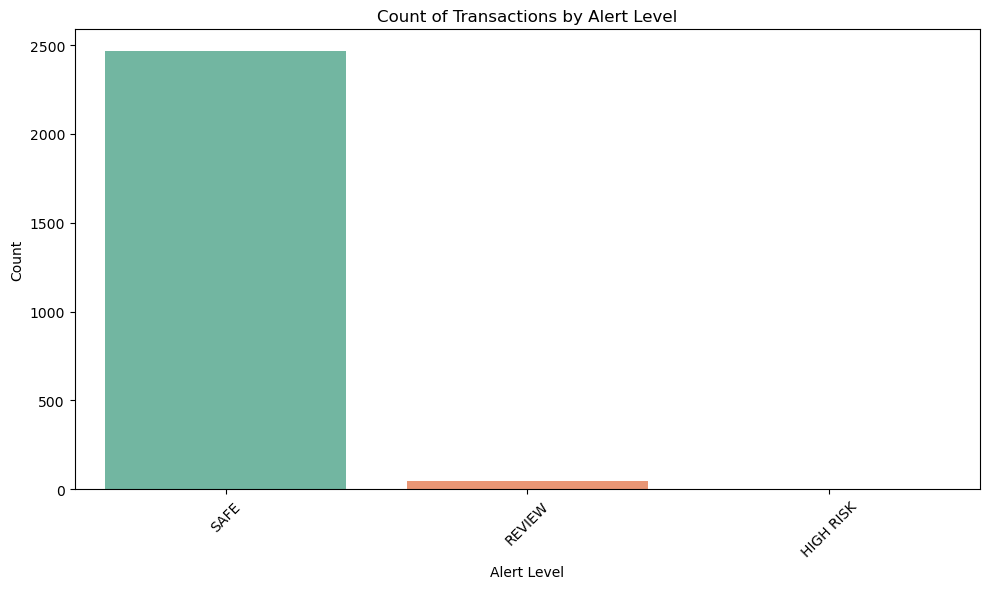

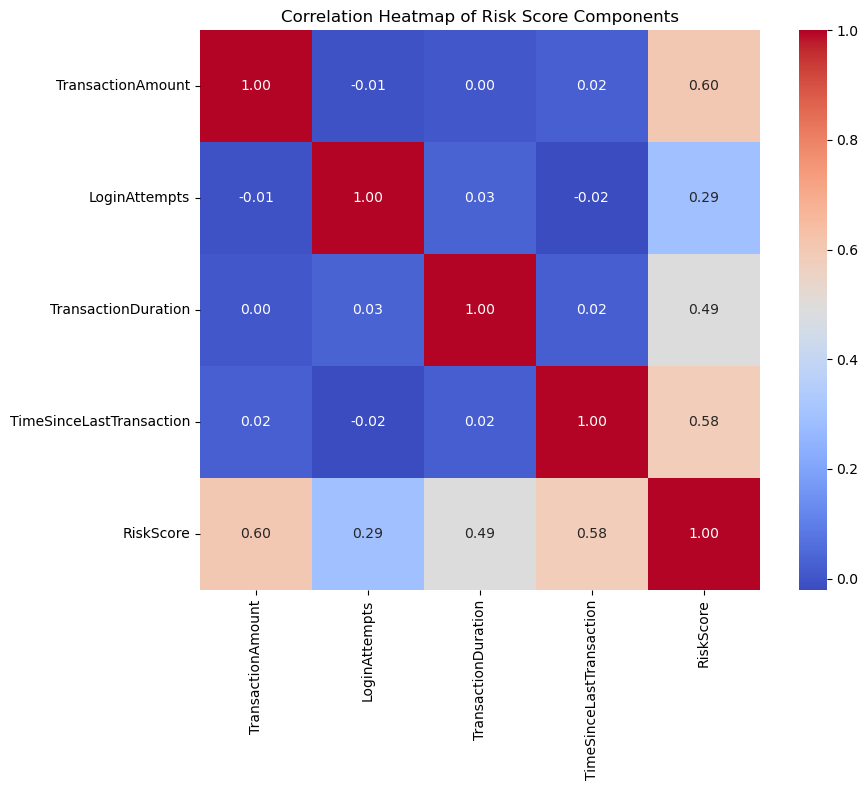

In [12]:
# --- Visualization ---

# Bar plot: count of each Alert Level
plt.figure(figsize=(10, 6))
sns.countplot(x='AlertLevel', data=df_model, palette='Set2')
plt.title('Count of Transactions by Alert Level')
plt.xlabel('Alert Level')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Correlation heatmap of Risk Score components
plt.figure(figsize=(10, 8))
corr = df_model[score_features + ['RiskScore']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Heatmap of Risk Score Components")
plt.tight_layout()
plt.show()